In [25]:
import numpy as np
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

In [26]:
snr_ranges = list(range(0,31,5))

sigma_list = []

for snr in snr_ranges:
    sigma_sq = 10**(-snr/10)
    sigma = sigma_sq**0.5
    sigma_list.append(sigma)

sigma_list

[1.0,
 0.5623413251903491,
 0.31622776601683794,
 0.17782794100389226,
 0.1,
 0.05623413251903491,
 0.03162277660168379]

In [35]:
def get_nmse(N, M, sigma):
    
    H_real = np.random.normal(0, 1, size=(N, M))
    H_imag = np.random.normal(0, 1, size=(N, M))

    # Combine real and imaginary parts of H
    H = H_real + 1j * H_imag

    # Generate a single sparse x (complex-valued)
    x_true_real = np.zeros(M)
    x_true_imag = np.zeros(M)
    non_zero_indices = np.random.choice(M, size=M // 10, replace=False)
    x_true_real[non_zero_indices] = np.random.normal(0, 1, size=M // 10)
    x_true_imag[non_zero_indices] = np.random.normal(0, 1, size=M // 10)
    x_true = x_true_real + 1j * x_true_imag

    # Generate observed Y with Gaussian noise (complex-valued)
    noise_real = np.random.normal(0, sigma, N)
    noise_imag = np.random.normal(0, sigma, N)
    noise = noise_real + 1j * noise_imag
    Y = H @ x_true + noise
    Y_real = np.real(Y).flatten()
    Y_imag = np.imag(Y).flatten()

    print(Y_real.tolist())

    # Decompose H and Y into real and imaginary parts for Stan
    stan_data = {
        "N": N,
        "M": M,
        "Y_real": Y_real.tolist(),
        "Y_imag": Y_imag.tolist(),
        "H_real": H_real,
        "H_imag": H_imag,
        "sigma": sigma,
        "alpha": 1,
    }

    model = CmdStanModel(stan_file="latent.stan")
    fit = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000, max_treedepth=15)

    posterior_samples = fit.draws_pd()

    mean_x_real = np.array(posterior_samples.filter(like='x_real').mean())
    mean_x_imag = np.array(posterior_samples.filter(like='x_imag').mean())
    mean_x = mean_x_real + 1j * mean_x_imag

    norm_diff_squared = np.sum((x_true_real - mean_x_real)**2) + np.sum((x_true_imag - mean_x_imag)**2)
    norm_x_squared = np.sum(x_true**2)
    NMSE = norm_diff_squared / norm_x_squared


    return NMSE
    


In [36]:
NMSE_dict = {}

for i in range(len(sigma_list)):
    
    nmse_total = 0
    K = 1

    for iter in range(K):
        nmse_total += get_nmse(N=20, M=50, sigma=sigma_list[i])
    NMSE_dict[snr_ranges[i]] = nmse_total/K


19:37:38 - cmdstanpy - INFO - CmdStan start processing


[-1.39448987428429, -2.9924783857323436, 5.257210695187427, 2.5298375072364903, 6.279450482990319, 2.620195089841776, 3.066625795384766, -2.033824157372169, -3.1754204945396287, -2.1716185865065945, -0.38911938043257055, -0.022630583109806368, 0.22526840439733697, 3.5320237768128475, -0.07010058342963399, -4.239628576791535, 3.4089494440473658, -7.506391593837112, -3.933868287238272, -2.402899271446289]


chain 1 |          | 00:00 Status


19:37:38 - cmdstanpy - ERROR - Chain [3] error: error during processing Operation not permitted
19:37:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
19:37:38 - cmdstanpy - ERROR - Chain [2] error: error during processing Operation not permitted
19:37:38 - cmdstanpy - ERROR - Chain [4] error: error during processing Operation not permitted
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


19:37:38 - cmdstanpy - INFO - CmdStan done processing.


RuntimeError: Error during sampling:
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=Y; dims declared=(20); dims found=() (in 'latent.stan', line 4, column 2 to column 14)
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=Y; dims declared=(20); dims found=() (in 'latent.stan', line 4, column 2 to column 14)
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=Y; dims declared=(20); dims found=() (in 'latent.stan', line 4, column 2 to column 14)
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=Y; dims declared=(20); dims found=() (in 'latent.stan', line 4, column 2 to column 14)
Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/Users/namangupta/Desktop/itsstan/final_sbl/latent', 'id=1', 'random', 'seed=98766', 'data', 'file=/var/folders/cz/m0yy93q13flbm67m6wwr1ygh0000gn/T/tmpwelj4_00/gu_uc3f9.json', 'output', 'file=/var/folders/cz/m0yy93q13flbm67m6wwr1ygh0000gn/T/tmpwelj4_00/latentacp62odh/latent-20241211193738_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'adapt', 'engaged=1']
 retcodes=[1, 1, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/var/folders/cz/m0yy93q13flbm67m6wwr1ygh0000gn/T/tmpwelj4_00/latentacp62odh/latent-20241211193738_1.csv
 console_msgs (if any):
	/var/folders/cz/m0yy93q13flbm67m6wwr1ygh0000gn/T/tmpwelj4_00/latentacp62odh/latent-20241211193738_0-stdout.txt
Consider re-running with show_console=True if the above output is unclear!

In [26]:
NMSE_dict

{0: 0.3155169483265001,
 5: 0.26093578970400727,
 10: 0.12498450377592425,
 15: 0.013677091191246184,
 20: 0.011496479427680058,
 25: 0.0012063586537293992,
 30: 0.00045477121443793494}

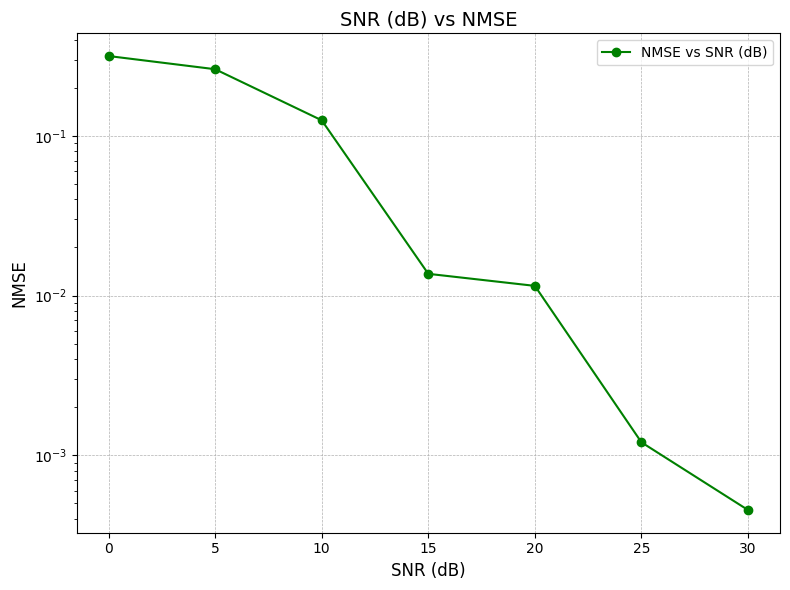

In [27]:
snr = list(NMSE_dict.keys())
nmse = list(NMSE_dict.values())
# nmse = [i[-1] for i in nmse]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(snr, nmse, marker='o', linestyle='-', color='g', label='NMSE vs SNR (dB)')
plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('NMSE', fontsize=12)
plt.title('SNR (dB) vs NMSE', fontsize=14)

# Set y-axis to logarithmic scale
plt.yscale('log')

plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()